#### Load required libraries

In [1]:
import  os
import  numpy as np
# Load pyviscous from local source
import sys
sys.path.append('..')
from pyviscous import pyviscous as vs
from pyviscous import plot as vsplt

#### Load Rosenbrock function
In the two-dimensional form, the Rosenbrock function is defined as ([Rosenbrock, 1960](https://doi.org/10.1093/comjnl/3.3.175)):
$$ y = {100(x_2-x_1^2)^2 + (1-x_1)^2}, x_1, x_2 \in [-2,2] $$

In [2]:
def Rosenbrock_function(x):
    ''' Rosenbrock function
    -------
    x: input array, shape (nSample,2).
    y: output array, shape (nSample,1).'''
    
    y = 100*np.power(x[:,1]-np.power(x[:,0],2),2) + np.power(1-x[:,0],2)
    
    if len(np.shape(y)) == 1: # if shape(nSample,) -> (nSample,1)
        y = y.reshape(-1,1) 

    return y

#### Configurations

In [2]:
# Specify global input and output configurations
rootPath  = '.'  # root path where example data will be stored.
outputDir = os.path.join(rootPath,'rosebrock')
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

nVar            = 2      # number of input x variables
paramLowerLimit = -2     # lower limit of x
paramUpperLimit = 2      # upper limit of x
nSample         = 10000  # number of input data samples
sampleFile      = os.path.join(outputDir,'samples_nVar%d.txt'%(nVar))

# Specify VISCOUS configurations
# Two options for sensitivity index calculation: 'first' or 'total' 
sensType        = 'first'  

# The evaluated input variable index, starting from zero.
xIndex          = 0     # An integer or a list with a single integer value. e.g., 0 or [0].
                        # Index 0 refers to the 1st input variable x1, meaning that we aim to calculate the sensitivity index of x1.                     
                        # When compute the sensitivity indices for multiple variables, please use a loop.
    

#### 1. Plot Rosenbrock function in 3D

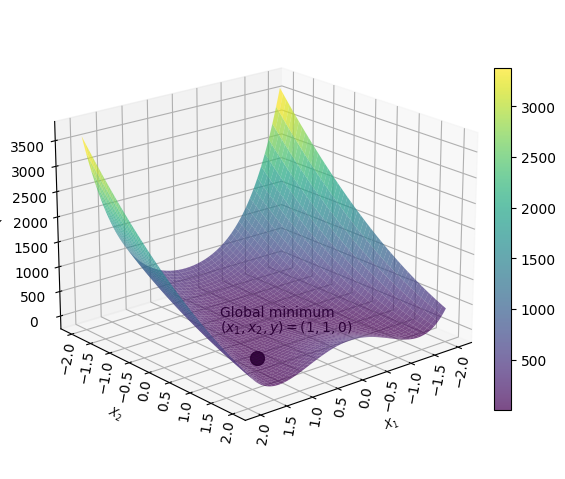

In [4]:
ofile= os.path.join(outputDir,'function_3D.png')
vsplt.plot_rosenbrock_3d(ofile)

#### 2. Generate input-output data

In [5]:
# Specify sample file.
if os.path.exists(sampleFile): # If exist, remove samples.
    os.remove(sampleFile)

# Generate input data (x) via uniform sampling throughout the feasible range.
x = np.zeros((nSample,nVar))
for iVar in range(nVar):
    prng = np.random.RandomState(iVar)
    x[:,iVar] = prng.uniform(low=paramLowerLimit, high=paramUpperLimit, size=nSample)               

# Generate the corresponding output data (y).
y = Rosenbrock_function(x)

# Save input-output data (x,y).
samples    = np.concatenate((x,y), axis=1)    
header_str = ','.join(['X'+str(iVar+1) for iVar in range(nVar)])+',Y'
np.savetxt(sampleFile, samples, delimiter=',', header=header_str)
print('Input-output data saved: %s'%(sampleFile))

Input-output data saved: ./rosebrock/samples_nVar2.txt


#### 3. Data conversion plot

##### Plot input-output, normalized, and CDF data
- When we compute the first-order sensitivity index of $x_1$ for the Rosenbrock function, two variables $(x_1,y)$ need included in the VISCOUS framework. 
- Through data preparation, three sets of data are obtained: input-output data $(x_1,y)$, normalized data $(x'_{1},y')$, and marginal CDF data $(u_{x_1},u_y)$.

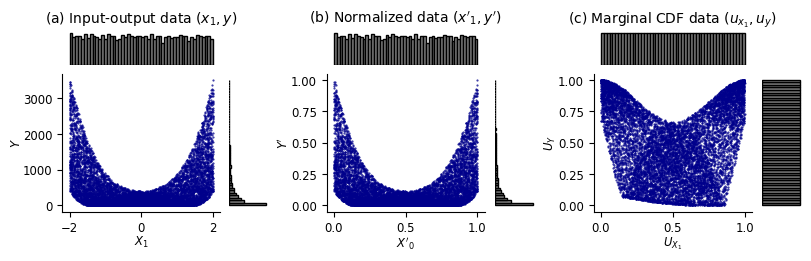

In [3]:
# Load input-output data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Plot data conversion (just for visulization)
ofile = os.path.join(outputDir,'data.png')
vsplt.plot_data_conversion(x,y,xIndex,ofile)

#### 4. Calculate the first-order sensitivity index using two components
##### 4.1 Calculate sensitivity index
Calculate the Sobol' first-order sensitivity index using two Gaussian components.

In [7]:
# Load input-output data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Calculate sensitivity indices using VISCOUS
sens_indx_2cpnt, gmcm_2cpnt = vs.viscous(x, y, xIndex, sensType, n_components=2)  

Calculating first-order sensitivity index for variable index 0...
--- PART A: Data preparation
--- PART B: GMCM inference
    n_component = 2
	initial 1: fitting completes with convergency.
--- PART C: Sensitivity index computation
    Best GMCM n_component =  2
    Sensitivity index = 0.444273


##### 4.2 Check the estiamted GMCM parameter values
- Mean and covariance are multivariate due to the multi-Gaussian-mixture nature of GMM. 
- Covariance is positive means that two random variables tend to vary in the same direction. Covariance is positive means that they vary in opposite directions. Covariance zero means that they don't vary together. 

In [15]:
gmm                = gmcm_2cpnt
gmmNComponents     = gmm.params.n_clusters    # number of components
gmmWeights         = gmm.params.prob          # shape (n_components,)
gmmMeans           = gmm.params.means         # shape (n_components, n_variables). n_variables = n_feature in sklearn.mixture.GaussianMixture reference.
gmmCovariances     = gmm.params.covs          # (n_components, n_variables, n_variables) if covariance_type = ‘full’ (by default).    

print(gmmNComponents)

2


##### 4.3 Plot the inverse CDF data, their PDFs and clusters in GMM
- $(z_{x_1},z_y)$ are the inverse CDFs of $(u_{x_1},u_y)$ in the fitted GMCM.<br>
- Plot the histogram (panel a), GMM PDF (panel b), and GMM clustering (panel c) results for $(z_{x_1},z_y)$. <br>
- Note that due to the randomness nature of the GMCM inference process, the GMCM inference results may vary each time.

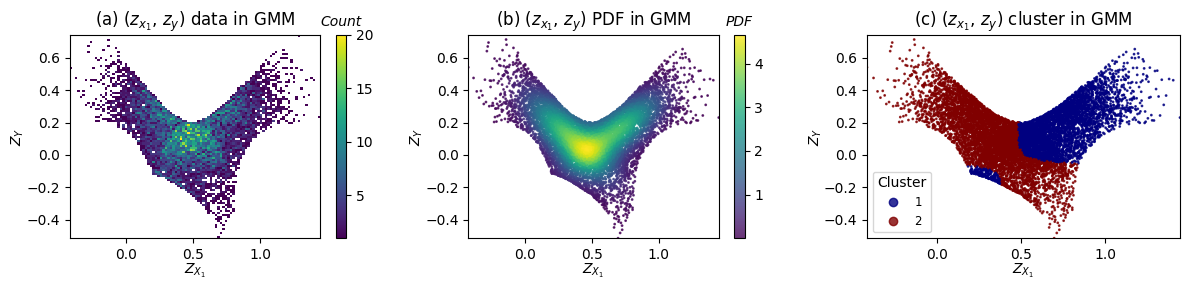

In [16]:
ofile = os.path.join(outputDir,'gmm_2cpnt.png')            # Output figure file
vsplt.plot_gmm_pdf_cluster(gmcm_2cpnt,x, y, xIndex, ofile) # Plot

#### 5. Calculate the first-order sensitivity index using am optimal number of components
##### 5.1 Calculate sensitivity index
Calculate the Sobol' first-order sensitivity index using an optimal number of Gaussian components.

In [18]:
# Load input-output data
data = np.loadtxt(sampleFile, skiprows=0, delimiter=',')
x    = data[:,0:-1]
y    = data[:,-1].reshape(-1,1)    

# Calculate sensitivity indices using VISCOUS
sens_indx_optm, gmcm_optm = vs.viscous(x, y, xIndex, sensType, n_components='optimal')  

Calculating first-order sensitivity index for variable index 0...
--- PART A: Data preparation
--- PART B: GMCM inference
    n_component = 2
	initial 1: fitting completes with convergency.
    n_component = 3
	initial 1: fitting completes with convergency.
    n_component = 4
	initial 1: fitting completes with convergency.
    n_component = 5
	initial 1: fitting completes with convergency.
    n_component = 6
	initial 1: fitting completes with convergency.
    n_component = 7
	initial 1: fitting completes with convergency.
    n_component = 8
	initial 1: fitting completes with convergency.
    n_component = 9
	initial 1: fitting completes with convergency.
--- PART C: Sensitivity index computation
    Best GMCM n_component =  9
    Sensitivity index = 0.543974


##### 5.2 Check the estiamted GMCM parameter values

In [19]:
gmm                = gmcm_optm
gmmNComponents     = gmm.params.n_clusters    # number of components
gmmWeights         = gmm.params.prob          # shape (n_components,)
gmmMeans           = gmm.params.means         # shape (n_components, n_variables). n_variables = n_feature in sklearn.mixture.GaussianMixture reference.
gmmCovariances     = gmm.params.covs          # (n_components, n_variables, n_variables) if covariance_type = ‘full’ (by default).    

print(gmmNComponents)

9


##### 5.2 Plot the inverse CDF data, their PDFs and clusters in GMM

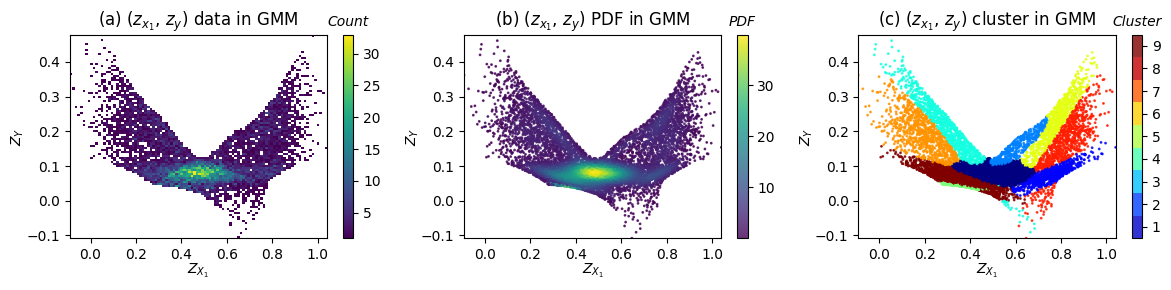

In [20]:
ofile = os.path.join(outputDir,'gmm_optimal_cpnt.png')  # Output figure file
vsplt.plot_gmm_pdf_cluster(gmcm_optm,x,y,xIndex,ofile)  # Plot

#### 6. Optional plots for better understanding GMM
##### 6.1 Plot the GMM individual components
When using two Gaussian components, plot the individual GMM components in the format of contour. A weighted mixture of all components constitutes the GMM. This plot is to help visualize how multiple Gaussian components constitute the GMM.

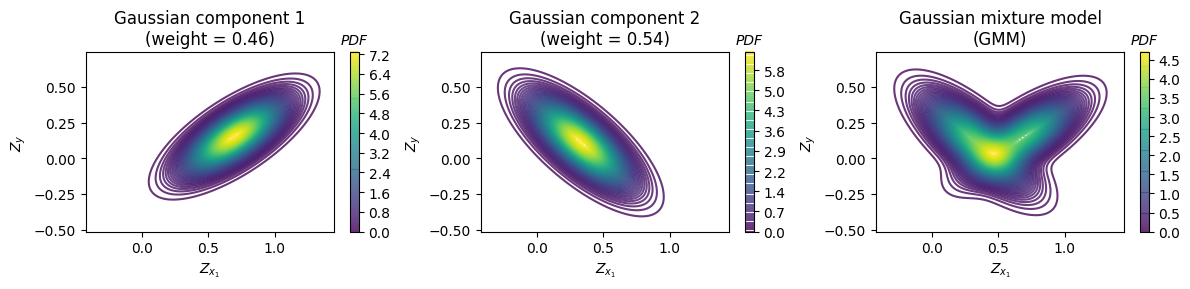

In [9]:
ofile = os.path.join(outputDir,'gmm_2cpnt_contour.png')  # Output figure file
vsplt.plot_gmm_counter(gmcm_2cpnt, x, y, xIndex, ofile)  # Plot

##### 6.2 Plot the means and covariances of GMM individual components
When using two Gaussian components, plot the means and covariances individual GMM components.

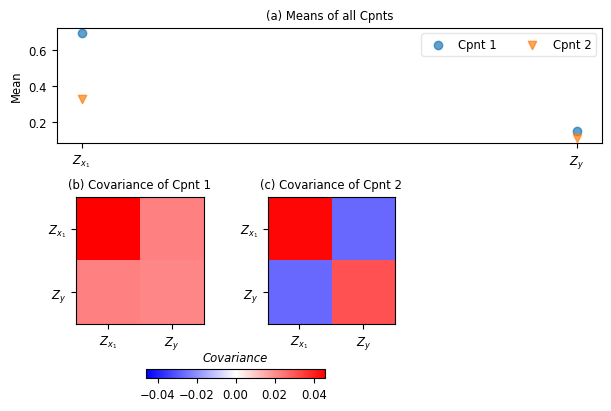

In [12]:
ofile = os.path.join(outputDir,'gmm_parameters_first_order.png') # Output figure file
vsplt.plot_gmm_mean_cov(gmcm_2cpnt, sensType, xIndex, ofile)     # Plot

##### 6.3 Plot GMM marginal distributions
Plot the histogram of $z_{x_1}$ and $z_y$ data in the marginal distributions of GMM. For example, <br>
- The first subplot shows the two histograms of $z_{x_1}$ data in the two $Z_{X_1}$ marginal distributions of GMM. <br>
- The two $Z_{X_1}$ marginal distributions are from the two GMM components. <br>

Note the following code is valid for the first-order sensitivity. Please adjust for use of the total-order sensitivity.
##### 6.3.1 GMM with two Gaussian components

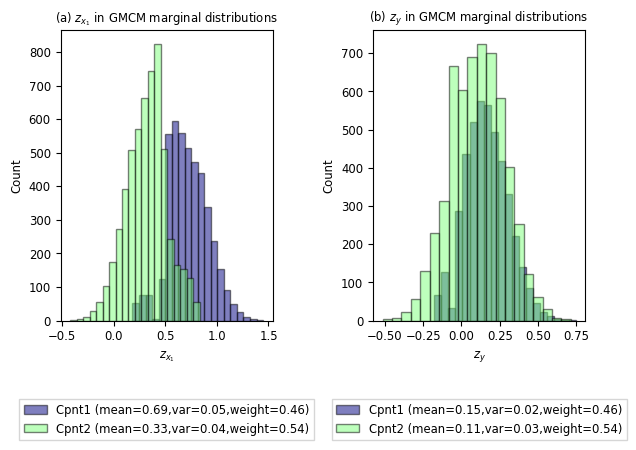

In [13]:
ofile = os.path.join(outputDir,'gmm_2cpnt_marginal_dists.png')   # Output figure file
vsplt.plot_gmm_marginal_dists(gmcm_2cpnt, x, y, xIndex, ofile)   # Plot

##### 6.3.2 GMM with an optimal number of Gaussian components

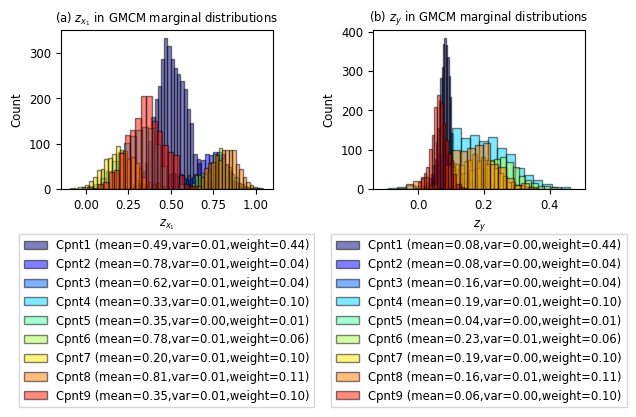

In [21]:
ofile = os.path.join(outputDir,'gmm_optm_cpnt_marginal_dists.png')  # Output figure file
vsplt.plot_gmm_marginal_dists(gmcm_optm, x, y, xIndex, ofile)       # Plot